In [31]:
from dataclasses import dataclass
from datetime import datetime

import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer
import os

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [32]:
batch_size = 128

nz = 100 
ngf = 32 
ngpu = 1

niter = 15

prefix = f"fuzzy_gan_anomaly_detection"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load MNIST

In [33]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [34]:
def get_target_and_mask(target_label):
    """
    Args:
    
    Returns:
    
    """
    
    t = torch.zeros(10)
    t[target_label] = 1.0
    
    return t.to(device) 

In [35]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(train_data)

60000

In [36]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

In [37]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)


### Load EMNIST

In [38]:
emnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.zip")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 

emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32, device=device) for a in emnist_x]

len(emnist_x)

emnist_mapping = pd.read_csv("./data/EMNIST/emnist-letters-mapping.txt", sep=' ', header=None)
emnist_mapping.columns=("EMNIST","UP","LO")
emnist_mapping["Letter"] = emnist_mapping.apply(lambda row: chr(row["UP"])+chr(row["LO"]), axis=1)
emnist_mapping = dict(zip(emnist_mapping["EMNIST"], emnist_mapping["Letter"]))

emnist_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.stack(emnist_x), torch.Tensor(np.array(emnist_y))), 
    batch_size=batch_size, 
    shuffle=False,
)

/tmp/ipykernel_1624057/58620865.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32, device=device) for a in emnist_x]


## DCGAN Model

In [39]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [40]:
class Generator(nn.Module):
    def __init__(self, ngpu, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

netG = Generator(ngpu).to(device)
netG.apply(weights_init)
num_params = sum(p.numel() for p in netG.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
#netG.load_state_dict(torch.load('weights/netG_epoch_99.pth'))
print(netG)

Number of parameters: 3,573,696
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bia

In [41]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, 1, 2, 1, 1, bias=False),
            nn.BatchNorm2d(1),
            nn.Flatten(),
            nn.Linear(16, 2),
        )
        self.latent_dim = 2
        self.fuzzlets = 20
        
        #theta = np.linspace(0, 2*np.pi, self.fuzzlets+1)
        #a, b = 0.1 * np.cos(theta), 0.1 * np.sin(theta)

        self.core = nn.Sequential(
            FuzzyLayer.from_dimensions(self.latent_dim, self.fuzzlets),#from_centers_and_scales([[x[0],x[1]] for x in zip(a,b)][:-1], [[1, 1] for x in zip(a,b)][:-1]),
            #DefuzzyLinearLayer.from_dimensions(self.fuzzlets, 1)
        )
    

    def forward(self, input):
        #batch_size = input.shape[0]
        output = self.main(input)
        c = self.core(output)
        
        #centroids_c = self.core[0].get_centroids()
        #average_cenroid_c = centroids_c.mean(0).reshape((1,-1))
        #dists = torch.cdist(output, average_cenroid_c, p=2).squeeze()
        #torch.cdist(centroids_c, output, p=2)
        # winner_fake = f.max(-1).values
        # centroids_f = self.fake[0].get_centroids()
        # average_cenroid_f = centroids_f.mean(0)

        # с_winners = torch.randint(0, self.fuzzlets, (batch_size, )).to(device)
        # random_centroids = centroids_c[с_winners]
        # firing_of_random = c.gather(1, с_winners.reshape((batch_size, 1))).squeeze()

        return c.sum(-1).squeeze()
    
    # def forward2(self, input):
    #     batch_size = input.shape[0]
    #     output = self.main(input)
    #     c = self.core(output)
        
    #     centroids_c = self.core[0].centroids.squeeze(-1)

    #     с_winners = torch.randint(0, self.fuzzlets, (batch_size, )).to(device)
    #     centroids_c = centroids_c[с_winners]
        
    #     c = c.gather(1, с_winners.reshape((batch_size, 1))).squeeze()    
    #     return c, (output - centroids_c).abs().sum(-1)
    
    def freeze_encoder(self):
        #self.core[0].set_requires_grad_rot(False)
        self.main.requires_grad_(False)
    
    def arate(self, input):
        output = self.main(input)
        c = self.core(output)
        return c.max(-1).values
    

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
num_params = sum(p.numel() for p in netD.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
print(netD)

Number of parameters: 658,312
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=16, out_features=2, bias=True)
  )
  (core): Sequential(
    (0): FuzzyLayer(
      

In [42]:
inp = torch.rand(4, 1, 28, 28).to(device)
dd = Discriminator(1).to(device)
dd(inp)

tensor([5.3412, 7.5901, 5.6205, 7.7884], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

## Train

In [43]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.001, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [44]:
def keep_eigenvals_positive_loss(d, eps = 1e-3):
    ev = d.core[0].get_transformation_matrix_eigenvals().real.min()
    ev = torch.where(ev > eps, eps, ev)
    return -ev

def gas_temperature(d, target_min, target_max):
    c = d.get_centroids()
    #dists = torch.cdist(c, c, p = 1)
    #nonzero = dists[torch.triu(torch.ones_like(dists), diagonal=1) == 1]
    #diff_max = (nonzero - target_max).max()
    #diff_min = (target_min - nonzero).max()
    
    average_cenroid_c = c.mean(0)
    nonzero = torch.cdist(c, average_cenroid_c.reshape((1,-1)), p = 2)
    diff_max = (nonzero - target_max).max()
    diff_min = (target_min - nonzero).max()
    discrep = torch.maximum(diff_max, diff_min)
    
    return discrep.where(discrep > 0,0)

In [45]:
def get_test_arate_distr(D):
    firing_levels = []
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for data, _ in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = D.arate(data)
            firing_levels.append(rates.cpu().numpy())
            

    firing_levels = np.concatenate(firing_levels, axis=0)
    for p in firing_levels:
        lab_true.append(1)
        lab_pred.append(p)

    with torch.no_grad():
        for data, labels in tqdm(emnist_loader, desc='Test EMNIST', disable=True):
            data = data.view((-1, 1, 28, 28)).to(device) 
            arate = D.arate(data)
            
            for p in arate.cpu().numpy():
                lab_true.append(0)
                lab_pred.append(p)
                
    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)

    return firing_levels, roc_auc

def draw_embeddings(epoch):
    centroids_core = netD.core[0].get_centroids().detach().cpu().numpy()
    
    embedings = []
    embedings_test = []
    labels_expected = []
    
    cnt = 3
    with torch.no_grad():
        for data, target in tqdm(train_loader, desc='Encoding', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            embeding = netD.main(data)
            embedings.append(embeding.cpu().numpy())
            labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))
            cnt -= 1
            if cnt < 0:
                break
            
    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    cnt = 3
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Encoding', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            embeding = netD.main(data)
            embedings_test.append(embeding.cpu().numpy())
            cnt -= 1
            if cnt < 0:
                break
    embedings_test = np.concatenate(embedings_test, axis=0)

    embedings_fake = []

    with torch.no_grad():
        batch_size = 256
        latent_size = 100
        
        fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
        if torch.cuda.is_available():
            fixed_noise = fixed_noise.cuda()
        fake_images = netG(fixed_noise)
        embeding = netD.main(fake_images)
        embedings_fake.append(embeding.cpu().numpy())

    embedings_fake = np.concatenate(embedings_fake, axis=0)    

    plt.figure(figsize=(12, 6))

    R, C = 1, 2

    plt.subplot(R, C, 1)
    plt.scatter(embedings[:, 0], embedings[:, 1], c=labels_expected, cmap='tab10', s=16)
    plt.scatter(embedings_test[:, 0], embedings_test[:, 1], marker='+', c='red', s = 1)
    
    plt.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='black', marker='o', s=16)
    plt.scatter(centroids_core[:, 0], centroids_core[:,1], marker='1', c='blue', s= 120)
    plt.subplot(R, C, 2)
    plt.scatter(embedings_test[:, 0], embedings_test[:, 1], c='red', s=20)
    plt.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='black', marker='o', s=20)
    plt.scatter(centroids_core[:,0], centroids_core[:, 1], marker='1', c='blue', s= 120)

    plt.show()
    #writer.add_figure('Embeddings', fig, epoch)

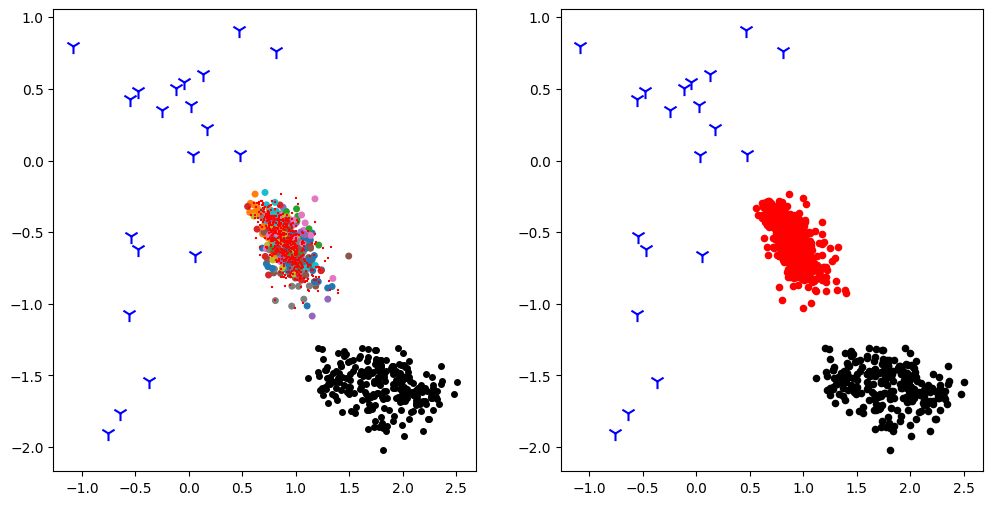

Epoch 0/15
{'G': 0.3791343316307732, 'POS': 9.202040530280518, 'NEG': 0.8192361469970328, 'q20': 0.3635152578353882, 'q80': 0.49889705777168275, 'auc': 0.8765422417953667}


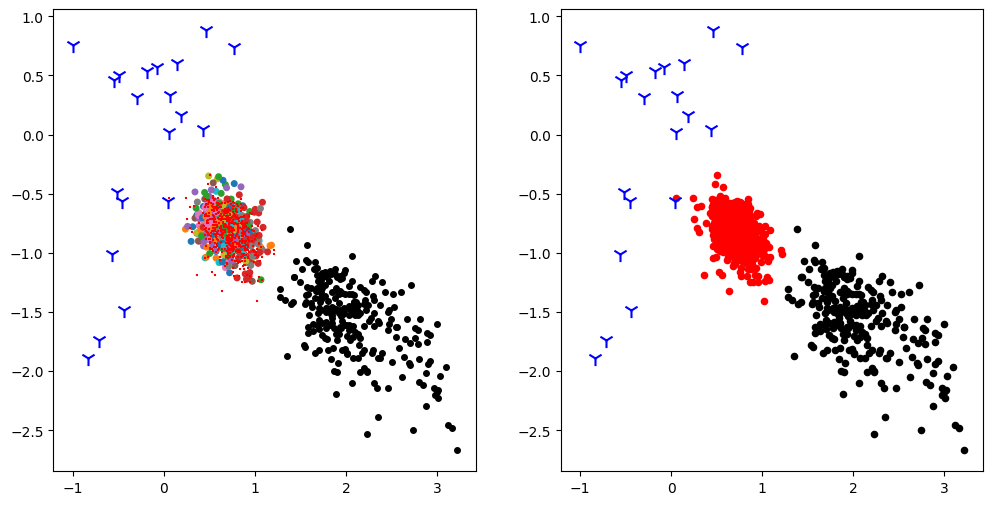

Epoch 1/15
{'G': 0.7836469088408993, 'POS': 9.925089454854222, 'NEG': 0.3128913181867681, 'q20': 0.31950289011001587, 'q80': 0.4890199422836304, 'auc': 0.6024455902509652}


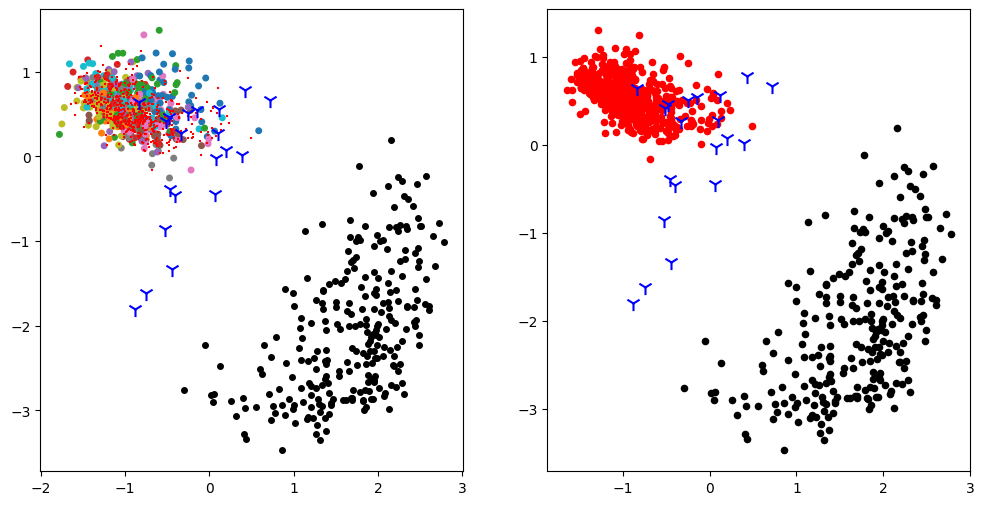

Epoch 2/15
{'G': 0.9654017499864482, 'POS': 9.870769288239957, 'NEG': 0.40351151962524284, 'q20': 0.5516617178916932, 'q80': 0.83523508310318, 'auc': 0.5846648489382239}


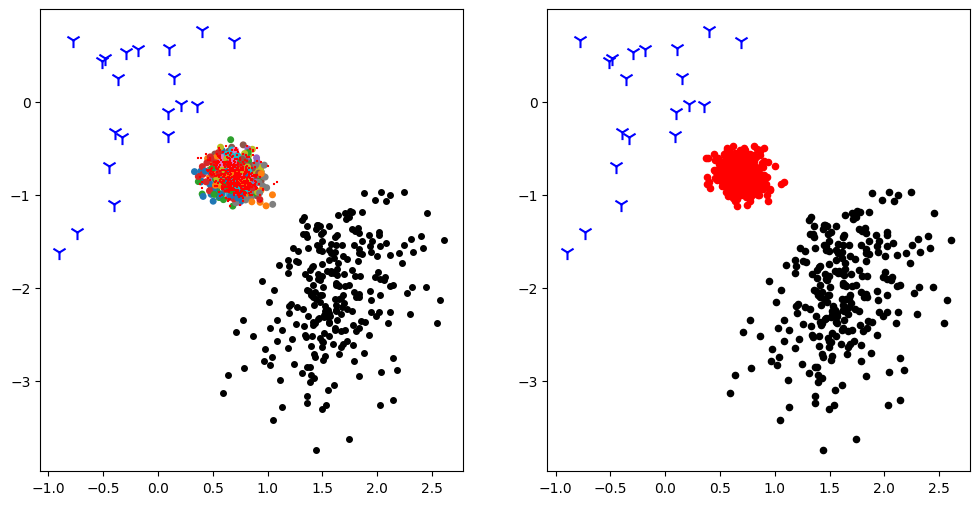

Epoch 3/15
{'G': 0.7806003824162331, 'POS': 9.793922064432712, 'NEG': 0.3462587270909535, 'q20': 0.30163122415542604, 'q80': 0.411985045671463, 'auc': 0.8281821988416989}


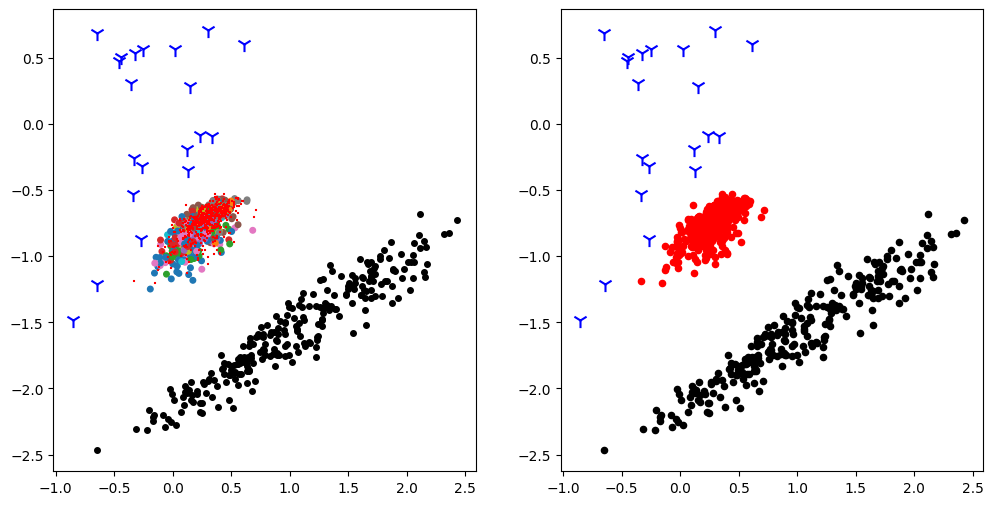

Epoch 4/15
{'G': 1.0449006979717121, 'POS': 9.875361075533478, 'NEG': 0.32839220981480977, 'q20': 0.5276682853698731, 'q80': 0.62272709608078, 'auc': 0.766819665057915}


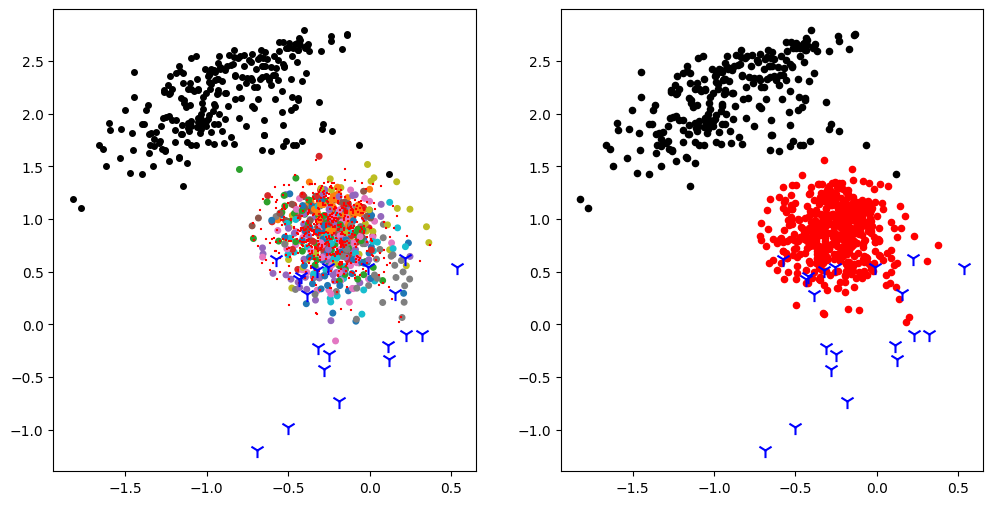

Epoch 5/15
{'G': 0.7973092486863451, 'POS': 9.953432183784209, 'NEG': 0.3729076508933039, 'q20': 0.5381994843482971, 'q80': 0.8552678942680358, 'auc': 0.6482806105212355}


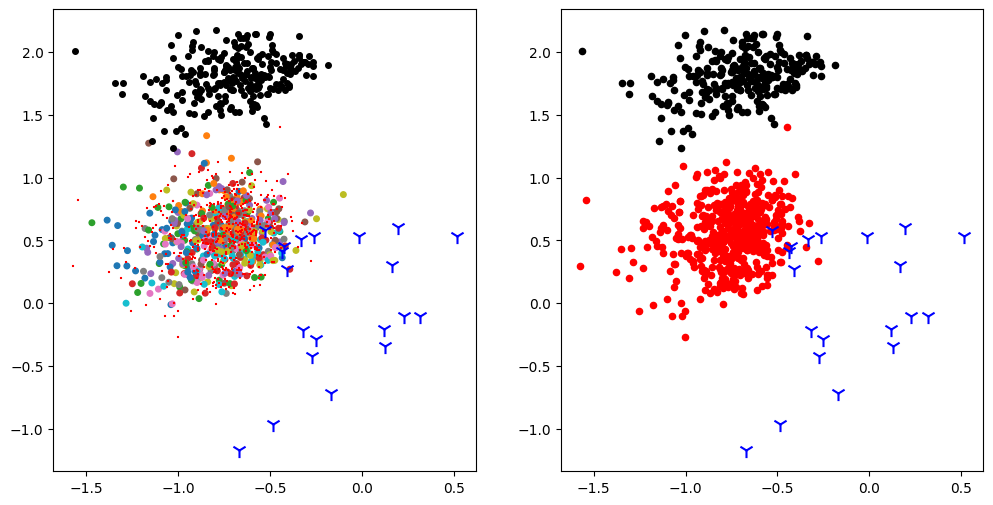

Epoch 6/15
{'G': 0.8555937966049861, 'POS': 9.98248188734563, 'NEG': 0.1303231546432892, 'q20': 0.5090963840484619, 'q80': 0.8150710344314576, 'auc': 0.9236028407335908}


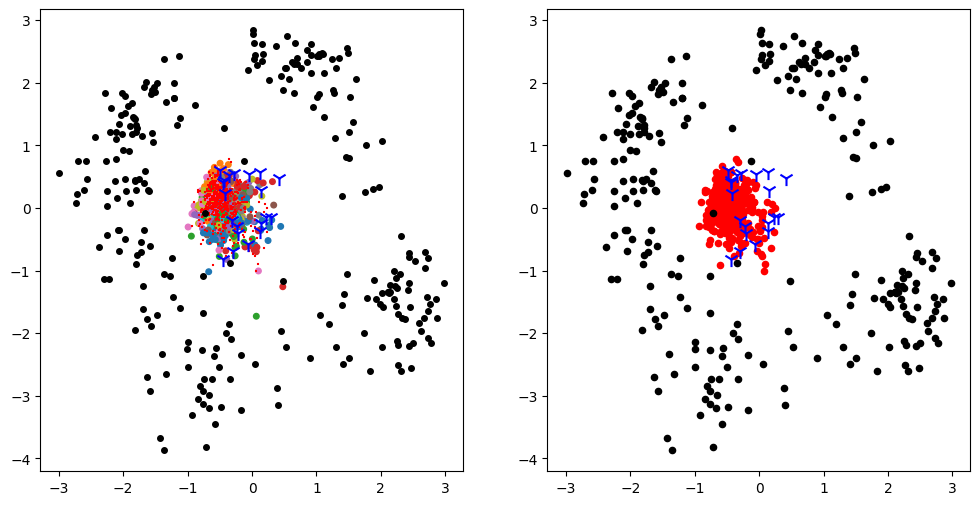

Epoch 7/15
{'G': 0.9261318910350678, 'POS': 9.896257946994513, 'NEG': 0.2820738261617196, 'q20': 0.7254406929016113, 'q80': 0.897077214717865, 'auc': 0.7625746129343629}


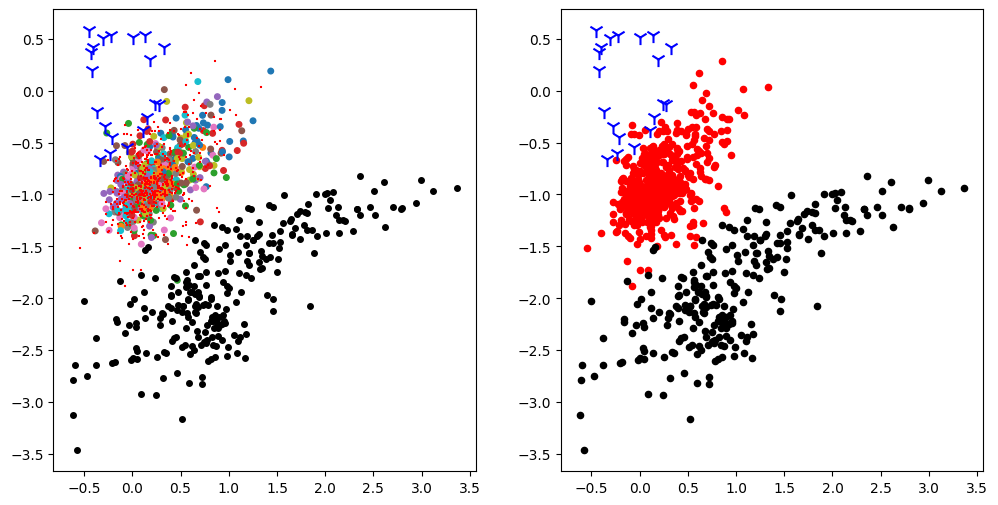

Epoch 8/15
{'G': 0.7959847260258599, 'POS': 9.934778134197568, 'NEG': 0.24850975301092876, 'q20': 0.34949603080749514, 'q80': 0.5742179155349731, 'auc': 0.8660071877413127}


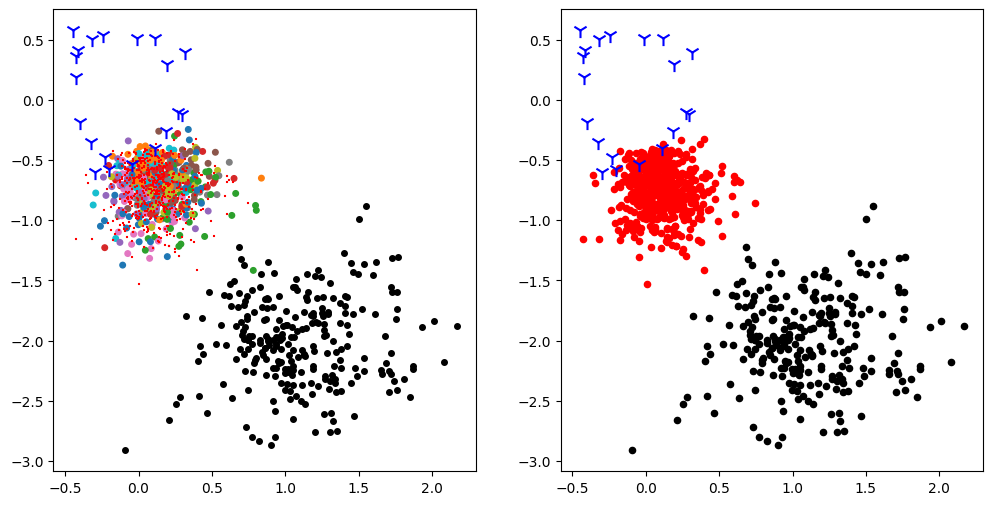

Epoch 9/15
{'G': 0.8776919491636728, 'POS': 9.927772514855684, 'NEG': 0.200807472004859, 'q20': 0.4683774530887604, 'q80': 0.8159205555915834, 'auc': 0.9009719802123551}


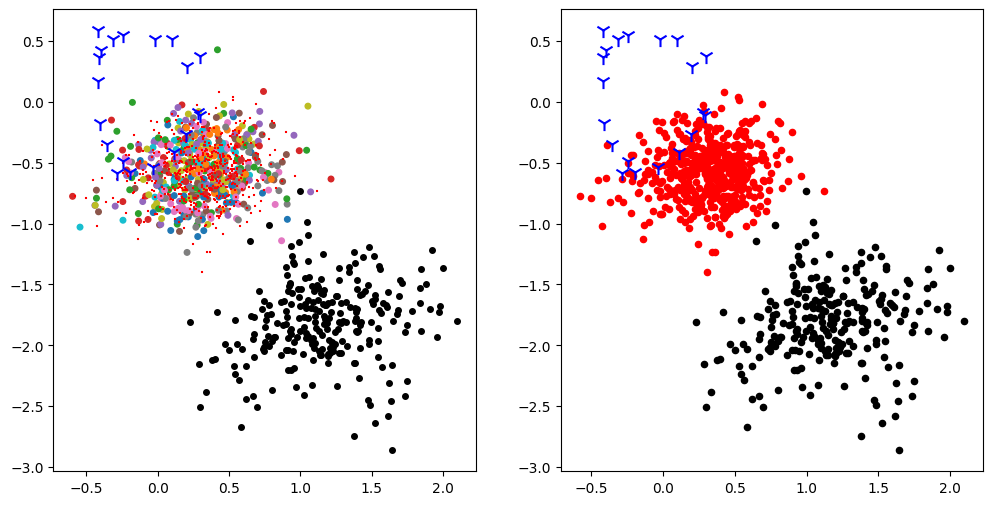

Epoch 10/15
{'G': 0.8303361894733616, 'POS': 9.965457196428831, 'NEG': 0.13760616631383127, 'q20': 0.5001136422157287, 'q80': 0.8339217066764831, 'auc': 0.7804582466216217}


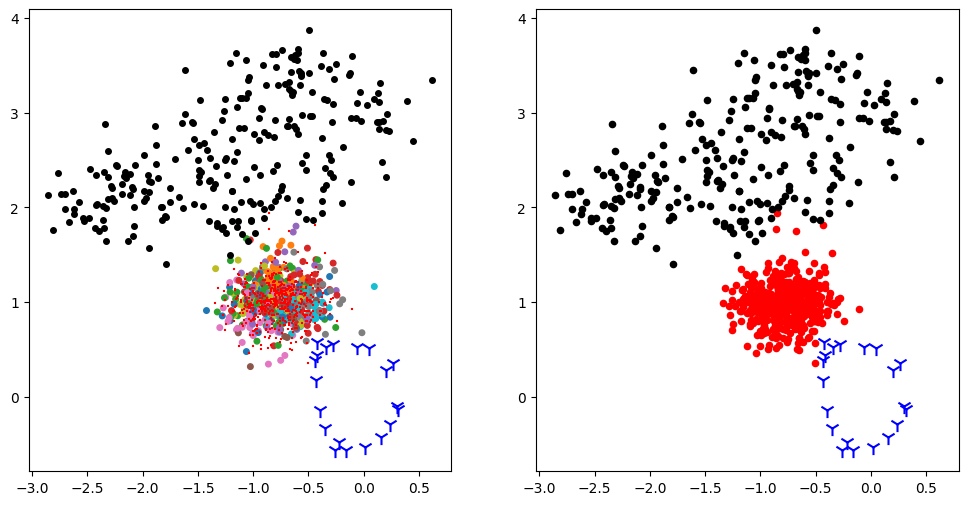

Epoch 11/15
{'G': 0.9705772568930441, 'POS': 9.924492543185952, 'NEG': 0.20462780855079768, 'q20': 0.35628000497817996, 'q80': 0.5516173720359803, 'auc': 0.8599914946911196}


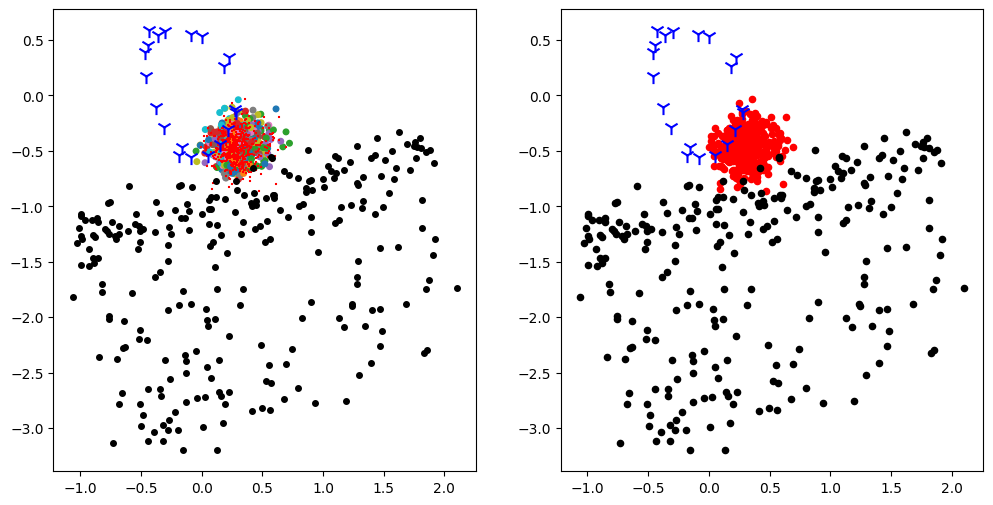

Epoch 12/15
{'G': 0.9666079790798078, 'POS': 9.879038006512086, 'NEG': 0.30659859725979094, 'q20': 0.7279285430908203, 'q80': 0.9221075296401977, 'auc': 0.7906091037644787}


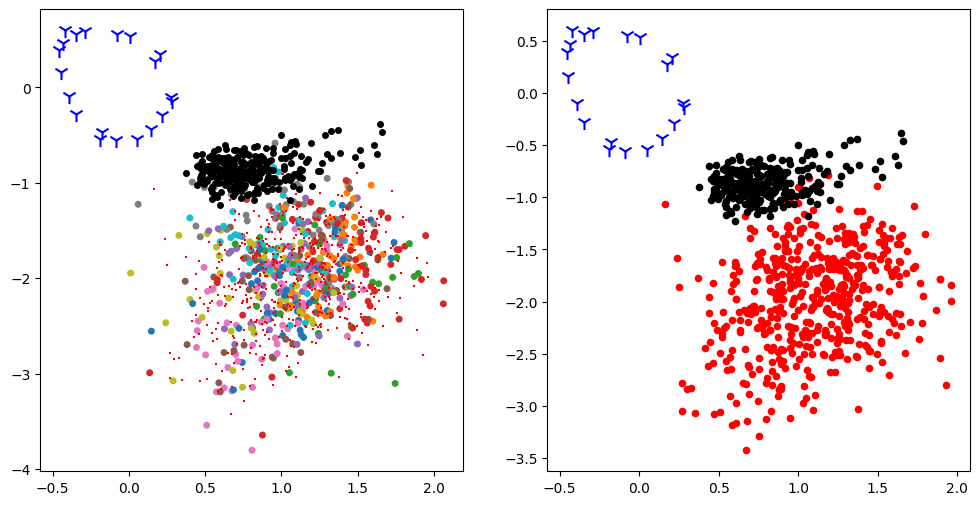

Epoch 13/15
{'G': 0.8057405268396142, 'POS': 9.966314272077353, 'NEG': 0.16822518768118644, 'q20': 0.04164615198969841, 'q80': 0.1116553843021393, 'auc': 0.6369676380308881}


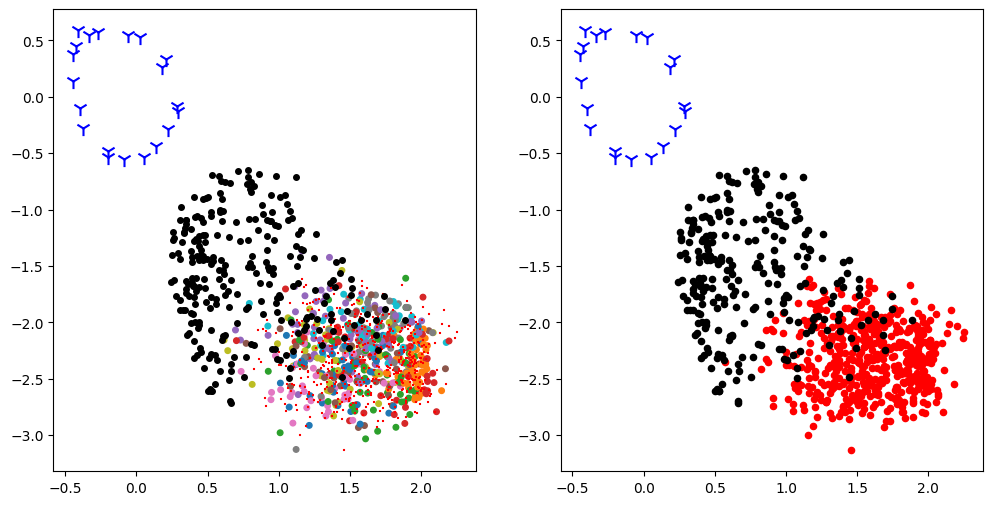

Epoch 14/15
{'G': 0.8464165425249762, 'POS': 9.99169743340661, 'NEG': 0.09902692100068908, 'q20': 0.019338148459792138, 'q80': 0.040917959064245224, 'auc': 0.5838675077220077}


In [46]:
for epoch in range(niter):

    netG.train()
    netD.train()
    report_aver_pos = 0
    report_aver_neg = 0
    report_loss_G = 0
    local_count = 0
    
    for i, data in enumerate(tqdm(train_loader, desc='Training', disable=True)):
        
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        
        netD.zero_grad()
        
        firing_c = netD(real_cpu)
        errD_real = torch.square(firing_c - 10).mean()
        errD_real.backward()
        
        neg_firing_c = netD(fake.detach())
        errD_fake = torch.square(neg_firing_c).mean()
        errD_fake.backward()
        
        optimizerD.step()
        
        netD.zero_grad()
        netG.zero_grad()
        gcore = netD(fake)
        errG = torch.square(gcore - 1).mean() 
        errG.backward()
        optimizerG.step()
        
        local_count += 1
        report_loss_G += errG.item()
        report_aver_pos += firing_c.mean().item()
        report_aver_neg += neg_firing_c.mean().item()
        
    netG.eval()
    netD.eval()

    losses = {}
    
    losses['G'] = report_loss_G / local_count
    losses['POS'] = report_aver_pos / local_count
    losses['NEG'] = report_aver_neg / local_count
    
    writer.add_scalars('Loss', losses, epoch)
    fake = netG(fixed_noise)
    writer.add_images('Generated images', fake.detach(), epoch)
    draw_embeddings(epoch)    
    
    mnist_distr, auc = get_test_arate_distr(netD)
    mnist_distr_q = {}
    mnist_distr_q["q20"] = np.quantile(mnist_distr, 0.2)
    mnist_distr_q["q80"] = np.quantile(mnist_distr, 0.8)
    writer.add_scalars("MNIST test  firings", mnist_distr_q, epoch)
    writer.add_scalar("AUC", auc, epoch)
    mnist_distr_q["auc"] = auc
    
    print(f"Epoch {epoch}/{niter}")
    print(losses | mnist_distr_q)
#draw_embeddings(epoch)
#num_gpu = 1 if torch.cuda.is_available() else 0

In [47]:
netD.core[0](torch.tensor([[0.2, -1.0]]).to(device))

tensor([[0.1135, 0.3515, 0.2760, 0.1827, 0.4156, 0.1095, 0.2240, 0.0620, 0.4116,
         0.1088, 0.3739, 0.1278, 0.0875, 0.1191, 0.4302, 0.1317, 0.3239, 0.1686,
         0.4410, 0.3823]], device='cuda:0', grad_fn=<TransposeBackward0>)

In [48]:
netD.core[0].get_centroids()

tensor([[-0.3326,  0.5507],
        [ 0.2894, -0.1258],
        [-0.3756, -0.2783],
        [ 0.1829,  0.2677],
        [-0.0903, -0.5520],
        [-0.2707,  0.5797],
        [-0.3984, -0.0985],
        [-0.4128,  0.5906],
        [ 0.2204, -0.2865],
        [-0.0564,  0.5484],
        [-0.1986, -0.5358],
        [-0.4485,  0.3797],
        [ 0.0232,  0.5295],
        [-0.4255,  0.4515],
        [ 0.0525, -0.5306],
        [ 0.2098,  0.3392],
        [ 0.2842, -0.0811],
        [-0.4433,  0.1368],
        [ 0.1385, -0.4359],
        [-0.1989, -0.4756]], device='cuda:0')

In [49]:
netD.core[0].get_transformation_matrix()

tensor([[[ 1.0287, -0.1680,  0.4347],
         [-0.1680,  1.2454, -0.7416],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.3044, -0.2846, -0.4133],
         [-0.2846,  1.2154,  0.2353],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.1088, -0.1467,  0.3756],
         [-0.1467,  1.3386,  0.3175],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.0380, -0.1175, -0.1584],
         [-0.1175,  1.3331, -0.3354],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.2658, -0.1304,  0.0423],
         [-0.1304,  1.6299,  0.8880],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.0016, -0.1224,  0.3421],
         [-0.1224,  1.2988, -0.7860],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.1917, -0.1361,  0.4613],
         [-0.1361,  1.2864,  0.0725],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.5489, -0.4014,  0.8765],
         [-0.4014,  1.2803, -0.9219],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 1.1044, -0.2991, -0.3291],
         [-0.2991,  1.2235,  0.416

## Валидация

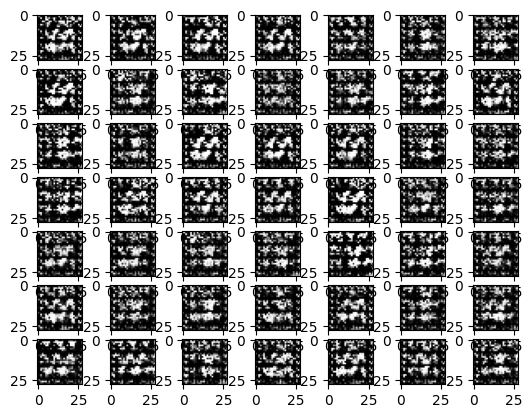

In [50]:
D = netD
G = netG
D.eval()
G.eval()

with torch.no_grad():
    batch_size = 49
    latent_size = 100
    
    fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
    if torch.cuda.is_available():
        fixed_noise = fixed_noise.cuda()
    fake_images = G(fixed_noise)

    fake_images_np = fake_images.cpu().detach().numpy()
    fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
    R, C = 7, 7
    for i in range(batch_size):
        plt.subplot(R, C, i + 1)
        plt.imshow(fake_images_np[i], cmap='gray')
    plt.show()

In [51]:
def get_arate(inp):
    output = D.main(inp)
    c = D.core(output)
    return c.sum(-1)
    
get_arate(inp.to(device))

tensor([0.0024, 0.0029, 0.0022, 0.0025], device='cuda:0',
       grad_fn=<SumBackward1>)

In [52]:
centroids_r = D.core[0].get_centroids().detach().cpu().numpy()
#centroids_f = D.fake[0].centroids.squeeze(-1).cpu().detach().numpy()
#centroids_r

In [53]:
embedings_fake = []

with torch.no_grad():
    batch_size = 256
    latent_size = 100
    
    fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
    if torch.cuda.is_available():
        fixed_noise = fixed_noise.cuda()
    fake_images = G(fixed_noise)
    embeding = D.main(fake_images)
    embedings_fake.append(embeding.cpu().numpy())

embedings_fake = np.concatenate(embedings_fake, axis=0)    

Encoding:   0%|          | 0/79 [00:00<?, ?it/s]

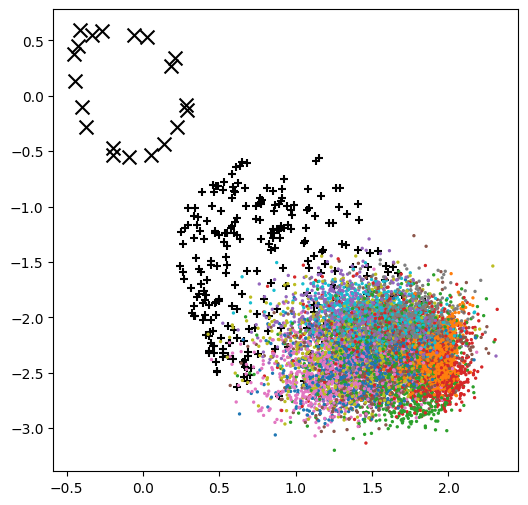

In [54]:
embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)
plt.figure(figsize=(6, 6))

R, C = 1, 1
cnt = 1
for i in range(1):
    plt.subplot(R, C, cnt)
    cnt += 1
    plt.scatter(embedings_fake[:, 2*i], embedings_fake[:, 2*i+1], c='black', marker='+', s=30)
    plt.scatter(embedings[:, 2*i], embedings[:, 2*i+1], c=labels_expected, cmap='tab10', s=2)
    plt.scatter(centroids_r[:,2*i], centroids_r[:,2*i+1], marker='x', c='black', s= 100)
    #plt.scatter(centroids_f[:,2*i], centroids_f[:,2*i+1], marker='o', c='red', s= 20)
    #plt.xlim(-0.5, 0.5)
    #plt.ylim(-0.5, 0.5)
#plt.colorbar()
plt.show()



Encoding:   0%|          | 0/810 [00:00<?, ?it/s]

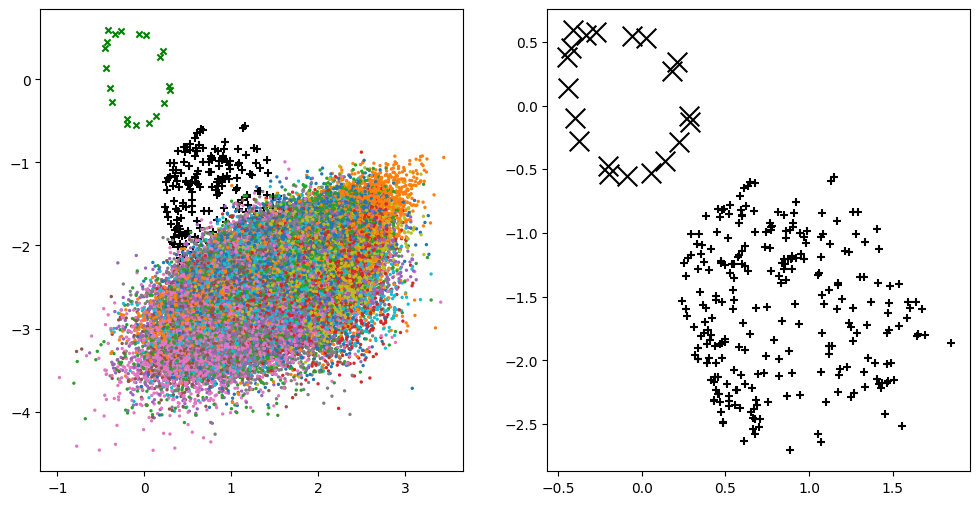

In [55]:
embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(emnist_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(target.cpu().numpy())
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)
plt.figure(figsize=(12, 6))

R, C = 1, 2

plt.subplot(R, C, 1)
plt.scatter(embedings_fake[:, 2*i], embedings_fake[:, 2*i+1], c='black', marker='+', s=30)
plt.scatter(embedings[:, 2*i], embedings[:, 2*i+1], c=labels_expected, cmap='tab10', s=2)
plt.scatter(centroids_r[:,2*i], centroids_r[:,2*i+1], marker='x', c='green', s= 20)
plt.subplot(R, C, 2)
plt.scatter(embedings_fake[:, 2*i], embedings_fake[:, 2*i+1], c='black', marker='+', s=30)
plt.scatter(centroids_r[:,2*i], centroids_r[:,2*i+1], marker='x', c='black', s= 200)

plt.show()

Encoding:   0%|          | 0/79 [00:00<?, ?it/s]

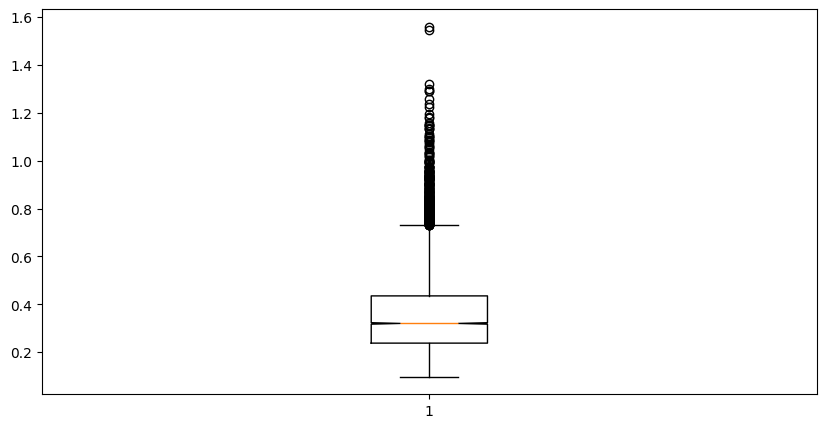

In [56]:
firing_levels = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        #output = D.main(data)
        #r = D.real(output)
        #rates = r

        firing_levels.append(rates.cpu().numpy())
        
firing_levels = np.concatenate(firing_levels, axis=0)
fig = plt.figure(figsize =(10, 5))
plt.boxplot(firing_levels, notch=True, showfliers=True)
plt.show()

In [57]:
firings_emnist = {}
for m in emnist_mapping:
    firings_emnist[emnist_mapping[m]] = []

with torch.no_grad():
    for data, labels in tqdm(emnist_loader, desc='Encoding'):
        data = data.view((-1, 1, 28, 28)).to(device) 
        arate = get_arate(data)
        #output = D.main(data)
        #r = D.real(output)
        #arate = 1 - r.sum(dim = 1)
        
        for label, flabel in zip(labels, arate.cpu().numpy()):
            firings_emnist[emnist_mapping[label.item()]].append(flabel)

Encoding:   0%|          | 0/810 [00:00<?, ?it/s]

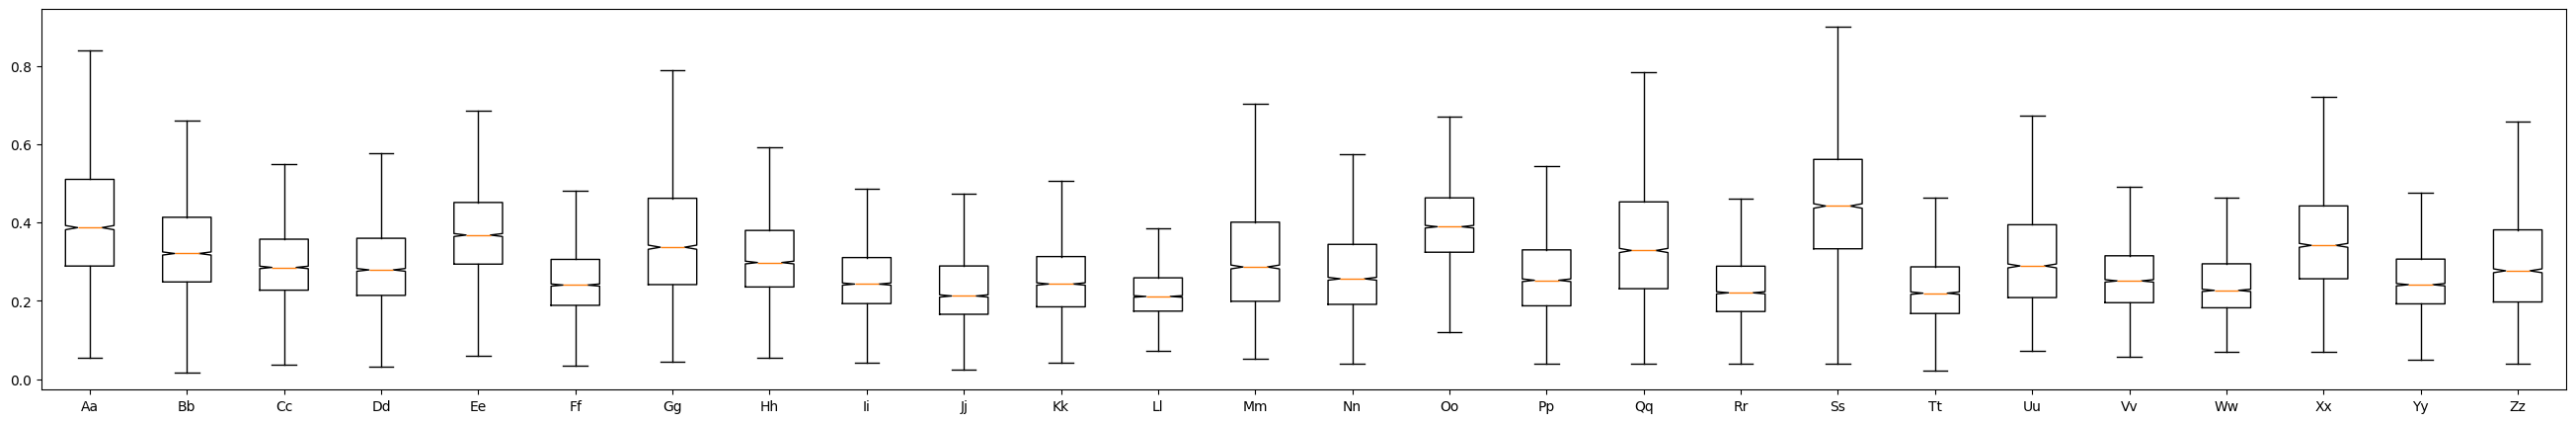

In [58]:
labels, data = firings_emnist.keys(), firings_emnist.values()
fig = plt.figure(figsize =(33, 5))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

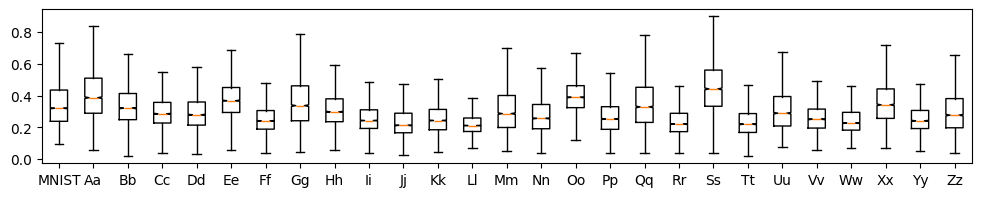

In [59]:
firings_mnist = {}
firings_mnist['MNIST'] = firing_levels
firings = {**firings_mnist, **firings_emnist} 
labels, data = firings.keys(), firings.values()

fig = plt.figure(figsize =(12, 2))
#plt.ylim(ymin=0)
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

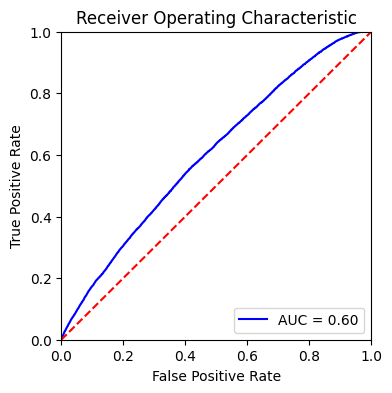

In [60]:
lab_true = []
lab_pred = []
for k,v in firings_mnist.items():
    for p in v:
        lab_true.append(1)
        lab_pred.append(p)
for k,v in firings_emnist.items():
    if k == 'Oo':
        continue
    for p in v:
        lab_true.append(0)
        lab_pred.append(p)

fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize =(4, 4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
writer.add_figure('ROC', fig)